# [**Itérations du "Successive Halving"**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/3_model_selection/plot_successive_halving_iterations.ipynb)<br/>([_Successive Halving Iterations_](https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html))

Cet exemple illustre comment une recherche "successive halving" ([**`HalvingGridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) et [**`HalvingRandomSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html)) choisit de manière itérative la meilleure combinaison de paramètres parmi plusieurs candidats.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

Tout d'abord, nous définissons l'espace des paramètres et entraînons une instance de [**`HalvingRandomSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html).

In [2]:
rng = np.random.RandomState(0)

X, y = datasets.make_classification(n_samples=400, n_features=12, random_state=rng)

clf = RandomForestClassifier(n_estimators=20, random_state=rng)

param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, 6),
    "min_samples_split": randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=rng
)
rsh.fit(X, y)

HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=RandomState(MT19937) at 0x1876A839D40),
                      factor=2,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001877C146550>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001877C71CB90>},
                      random_state=RandomState(MT19937) at 0x1876A839D40)

Nous pouvons maintenant utiliser l'attribut `cv_results_` de l'estimateur de recherche pour inspecter et tracer l'évolution de la recherche.

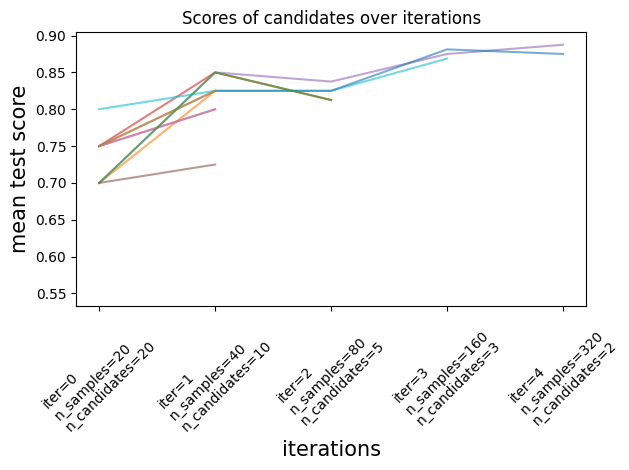

In [3]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

# Nombre de candidats et quantité de ressources à chaque itération

Lors de la première itération, une petite quantité de ressources est utilisée. La ressource ici est le nombre d'échantillons sur lesquels les estimateurs sont entraînés. Tous les candidats sont évalués.

Lors de la deuxième itération, seuls les meilleurs candidats de la première itération sont évalués. Le nombre de ressources allouées est doublé : les candidats sont évalués sur deux fois plus d'échantillons.

Ce processus est répété jusqu'à la dernière itération, où seuls 2 candidats restent. Le meilleur candidat est celui qui obtient le meilleur score à la dernière itération.